In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import sfp 
import torch
from torch.utils import data as torchdata
import glob
import os
import warnings
import itertools
import altair as alt
import arviz as az
import pymc3 as pm
import theano.tensor as tt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
sns.set_style('whitegrid')
df_path = "/mnt/winawerlab/Projects/spatial_frequency_preferences/BIDS/derivatives/simulated_data/noise-stim_class_posterior_sub-wlsubj045_ses-02_task-sfp_v1_e1-12/n100_iso_full_constant_s1_a.75_b.25_rmc0_rmo0_rac0_rao0_amc0_amo0_aac0_aao0_l1_simulated.csv"
#df_path = '/mnt/winawerlab/Projects/spatial_frequency_preferences/BIDS/derivatives/first_level_analysis/stim_class/posterior/sub-wlsubj045/ses-02/sub-wlsubj045_ses-02_task-sfp_v1_e1-12_summary.csv'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
df = pd.read_csv(df_path)

In [10]:
features = df[['local_sf_magnitude', 'local_sf_xy_direction', 'eccen', 'angle']]
targets = df[['amplitude_estimate_median']]
precision = df[['precision']]

In [11]:
def pymc_log_gauss_donut(features, targets, precision, orientation_type='iso', eccentricity_type='full', vary_amplitude=False):
    amp_vary_label = {False: 'constant', True: 'vary'}[vary_amplitude]
    name = '%s_donut_%s_amps-%s' % (eccentricity_type, orientation_type, amp_vary_label)
    random_param, param_val = {}, {}
    for ori, param, angle in itertools.product(['abs', 'rel'], ['mode', 'amplitude'],
                                               ['cardinals', 'obliques']):
        random_param['%s_%s_%s' % (ori, param, angle)] = True
        param_val['%s_%s_%s' % (ori, param, angle)] = 0
    for var in ['slope', 'intercept']:
        random_param['sf_ecc_%s' % var] = True
        param_val['sf_ecc_%s' % var] = .5
    param_val, random_param = sfp.model._check_log_gaussian_params(param_val, random_param, orientation_type, 
                                                                   eccentricity_type, vary_amplitude)
    params = {}
    sf_mag, sf_angle, vox_ecc, vox_angle = features.values.T
    model = pm.Model()
    with model:
        params['sigma'] = pm.Normal('sigma', mu=1, sd=.25)
        for k, v in param_val.items():
            if random_param[k]:
                params[k] = pm.Normal(k, mu=v, sd=.25)
            else:
                params[k] = pm.Deterministic(k, tt.as_tensor(v))
        rel_sf_angle = sf_angle - vox_angle
        eccentricity_effect = params['sf_ecc_slope'] * vox_ecc + params['sf_ecc_intercept']
        orientation_effect = (1 + params['abs_mode_cardinals'] * tt.cos(2 * sf_angle) +
                              params['abs_mode_obliques'] * tt.cos(4 * sf_angle) +
                              params['rel_mode_cardinals'] * tt.cos(2 * rel_sf_angle) +
                              params['rel_mode_obliques'] * tt.cos(4 * rel_sf_angle))
        preferred_period = pm.math.clip(pm.Deterministic('preferred_period', eccentricity_effect * orientation_effect),1e-6, 1e6)

        max_amplitude = pm.math.clip(pm.Deterministic('max_amplitude',
                                         (1 + params['abs_amplitude_cardinals'] * tt.cos(2*sf_angle) +
                                          params['abs_amplitude_obliques'] * tt.cos(4*sf_angle) +
                                          params['rel_amplitude_cardinals'] * tt.cos(2*rel_sf_angle) +
                                          params['rel_amplitude_obliques'] * tt.cos(4*rel_sf_angle))),1e-6, 1e6)
        pdf = pm.Deterministic('pdf', tt.exp(-((tt.log2(sf_mag) + tt.log2(preferred_period))**2) / (2*params['sigma']**2)))
        predicted_response = max_amplitude * pdf
        noisy_response = pm.Normal('noisy_response', mu=predicted_response, sd=1./precision, observed=targets)
        trace = pm.sample(chains=2)
        #prior = pm.sample_prior_predictive()
        #posterior_predictive = pm.sample_posterior_predictive(trace, 500)
    return model, trace, #prior, posterior_predictive

In [ ]:
iso_model, iso_trace = pymc_log_gauss_donut(features, targets, precision, 'iso')
# full_model, full_trace = pymc_log_gauss_donut(features, targets, precision, 'full')

In [ ]:
prior = pm.sample_prior_predictive(model=iso_model)
post = pm.sample_prior_predictive(trace, 500, iso_model)

In [1]:
data = az.from_pymc3(iso_trace, prior=prior, posterior_predictive=post)

NameError: name 'az' is not defined

In [38]:
dataset = sfp.model.FirstLevelDataset(df_path, device,)# sfp.model.construct_df_filter('drop_voxels_with_negative_amplitudes,drop_voxels_near_border'))
dataloader = torchdata.DataLoader(dataset, 1)

Need to rescale predictions and targets

In [8]:
model = sfp.model.LogGaussianDonut('iso', 'full')

def call_model(features, precision):
    priors = {}
    for k, v in model.named_parameters():
        if not v.requires_grad:
            # we only want to deal with the parameters that require training
            continue
        if k == 'sigma':
            priors[k] = pyro.distributions.Normal(features.new_tensor(1), features.new_tensor(.25))
        elif k.startswith('sf'):
            priors[k] = pyro.distributions.Normal(features.new_tensor(.5), features.new_tensor(.25))
        else:
            #priors[k] = pyro.distributions.Gamma(1, 5)
            priors[k] = pyro.distributions.Normal(features.new_tensor(.5), features.new_tensor(.25))
    lifted_module = pyro.random_module('module', model, priors)
    lifted_model = lifted_module()
    predictions = lifted_model(*features.transpose(2,0).transpose(2,1))
    rescaled_predictions = predictions / predictions.norm(2, -1, True)
    return pyro.sample('noisy_predictions', pyro.distributions.Normal(rescaled_predictions, 1./precision))

def call_conditioned_model(features, target, precision):
    rescaled_target = target / target.norm(2, -1, True)
    return pyro.condition(call_model, data={'noisy_predictions': rescaled_target})(features, precision)

In [9]:
features = []
targets = []
precision = []
for i in range(len(dataset)):
    f,t,p = dataset[i]
    features.append(f.reshape((*f.shape, 1)))
    targets.append(t.reshape(*t.shape, 1))
    precision.append(p.reshape(*p.shape, 1))
features = torch.cat(features, -1).transpose(2, 0).transpose(2, 1)
targets = torch.cat(targets, -1).transpose(1, 0)
precision = torch.cat(precision, -1).transpose(1, 0)

In [10]:
pyro.clear_param_store()
nuts_kernel = mcmc.NUTS(call_conditioned_model, adapt_step_size=True)
hmc = mcmc.MCMC(nuts_kernel, num_samples=100, num_chains=1)

In [11]:
hmc_posterior = hmc.run(features, targets, precision)

Sample: 100%|██████████| 200/200 [00:07<00:00, 25.65it/s, step size=1.80e-01, acc. rate=0.905]


In [12]:
pyro_data_iso = az.from_pyro(hmc_posterior)

In [17]:
pyro_data_iso.posterior

<xarray.Dataset>
Dimensions:                    (chain: 1, draw: 100)
Coordinates:
  * chain                      (chain) int64 0
  * draw                       (draw) int64 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
Data variables:
    module$$$sigma             (chain, draw) float64 0.9697 0.9786 ... 0.9788
    module$$$sf_ecc_slope      (chain, draw) float64 0.74 0.733 ... 0.7448
    module$$$sf_ecc_intercept  (chain, draw) float64 0.1867 0.2494 ... 0.1943
Attributes:
    created_at:                 2019-04-02T21:30:08.832168
    inference_library:          pyro
    inference_library_version:  0.3.1

In [18]:
pyro_data_full.posterior

<xarray.Dataset>
Dimensions:                           (chain: 1, draw: 100)
Coordinates:
  * chain                             (chain) int64 0
  * draw                              (draw) int64 0 1 2 3 4 ... 95 96 97 98 99
Data variables:
    module$$$sigma                    (chain, draw) float64 0.9748 ... 0.9711
    module$$$abs_amplitude_cardinals  (chain, draw) float64 0.003297 ... -0.002975
    module$$$abs_amplitude_obliques   (chain, draw) float64 -0.004145 ... 0.001009
    module$$$rel_amplitude_cardinals  (chain, draw) float64 -0.002018 ... -0.00707
    module$$$rel_amplitude_obliques   (chain, draw) float64 0.003386 ... -0.0009014
    module$$$abs_mode_cardinals       (chain, draw) float64 -0.001487 ... -0.005134
    module$$$abs_mode_obliques        (chain, draw) float64 -0.002583 ... -0.002509
    module$$$rel_mode_cardinals       (chain, draw) float64 -0.00794 ... -0.001675
    module$$$rel_mode_obliques        (chain, draw) float64 -0.0003585 ... 0.000501
    module$$$s

In [217]:
params = ['module$$$'+i[0] for i in model.named_parameters()]
marginals = hmc_posterior.marginal(params)
marginals.support().keys()

odict_keys(['module$$$sigma', 'module$$$abs_amplitude_cardinals', 'module$$$abs_amplitude_obliques', 'module$$$rel_amplitude_cardinals', 'module$$$rel_amplitude_obliques', 'module$$$abs_mode_cardinals', 'module$$$abs_mode_obliques', 'module$$$rel_mode_cardinals', 'module$$$rel_mode_obliques', 'module$$$sf_ecc_slope', 'module$$$sf_ecc_intercept'])

In [218]:
samples = {}
for k, v in marginals.support().items():
    samples[k.replace('module$$$', '')] = v
samples = pd.DataFrame(samples)
samples['sample_num'] = range(len(samples))
samples = pd.melt(samples, 'sample_num', var_name='model_parameter')

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


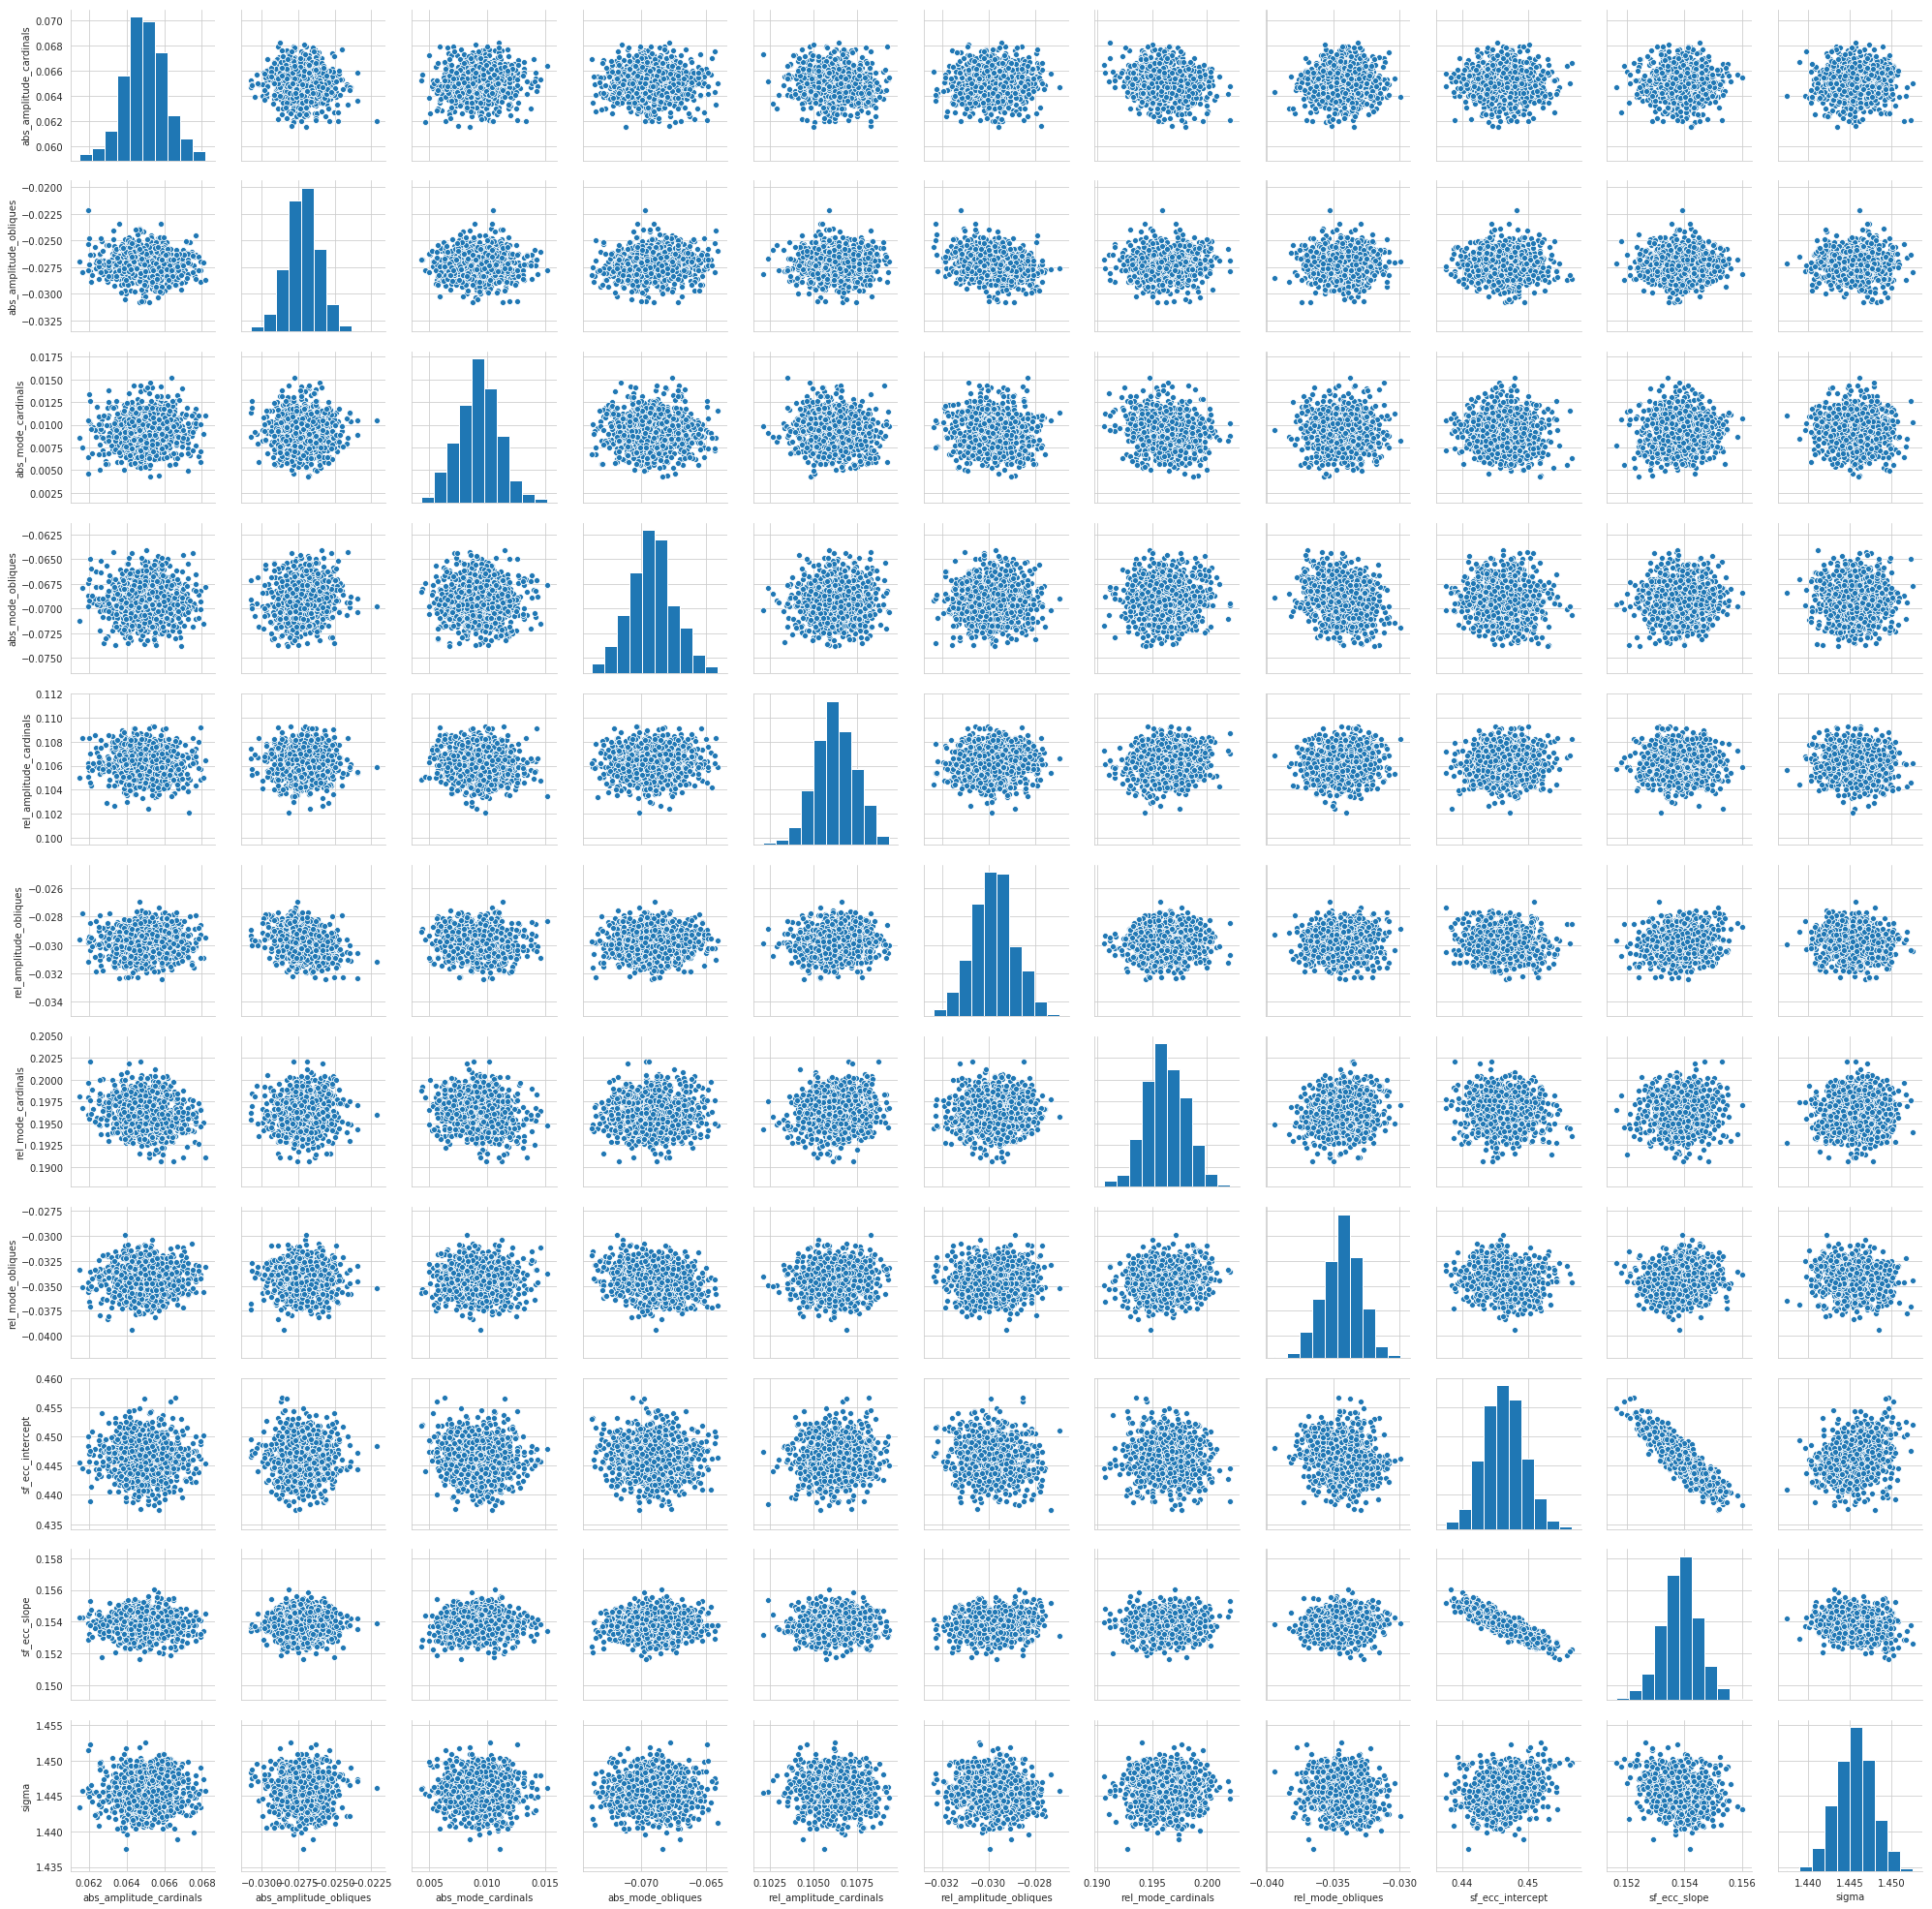

In [221]:
sns.pairplot(samples.pivot('sample_num', 'model_parameter', 'value'))

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


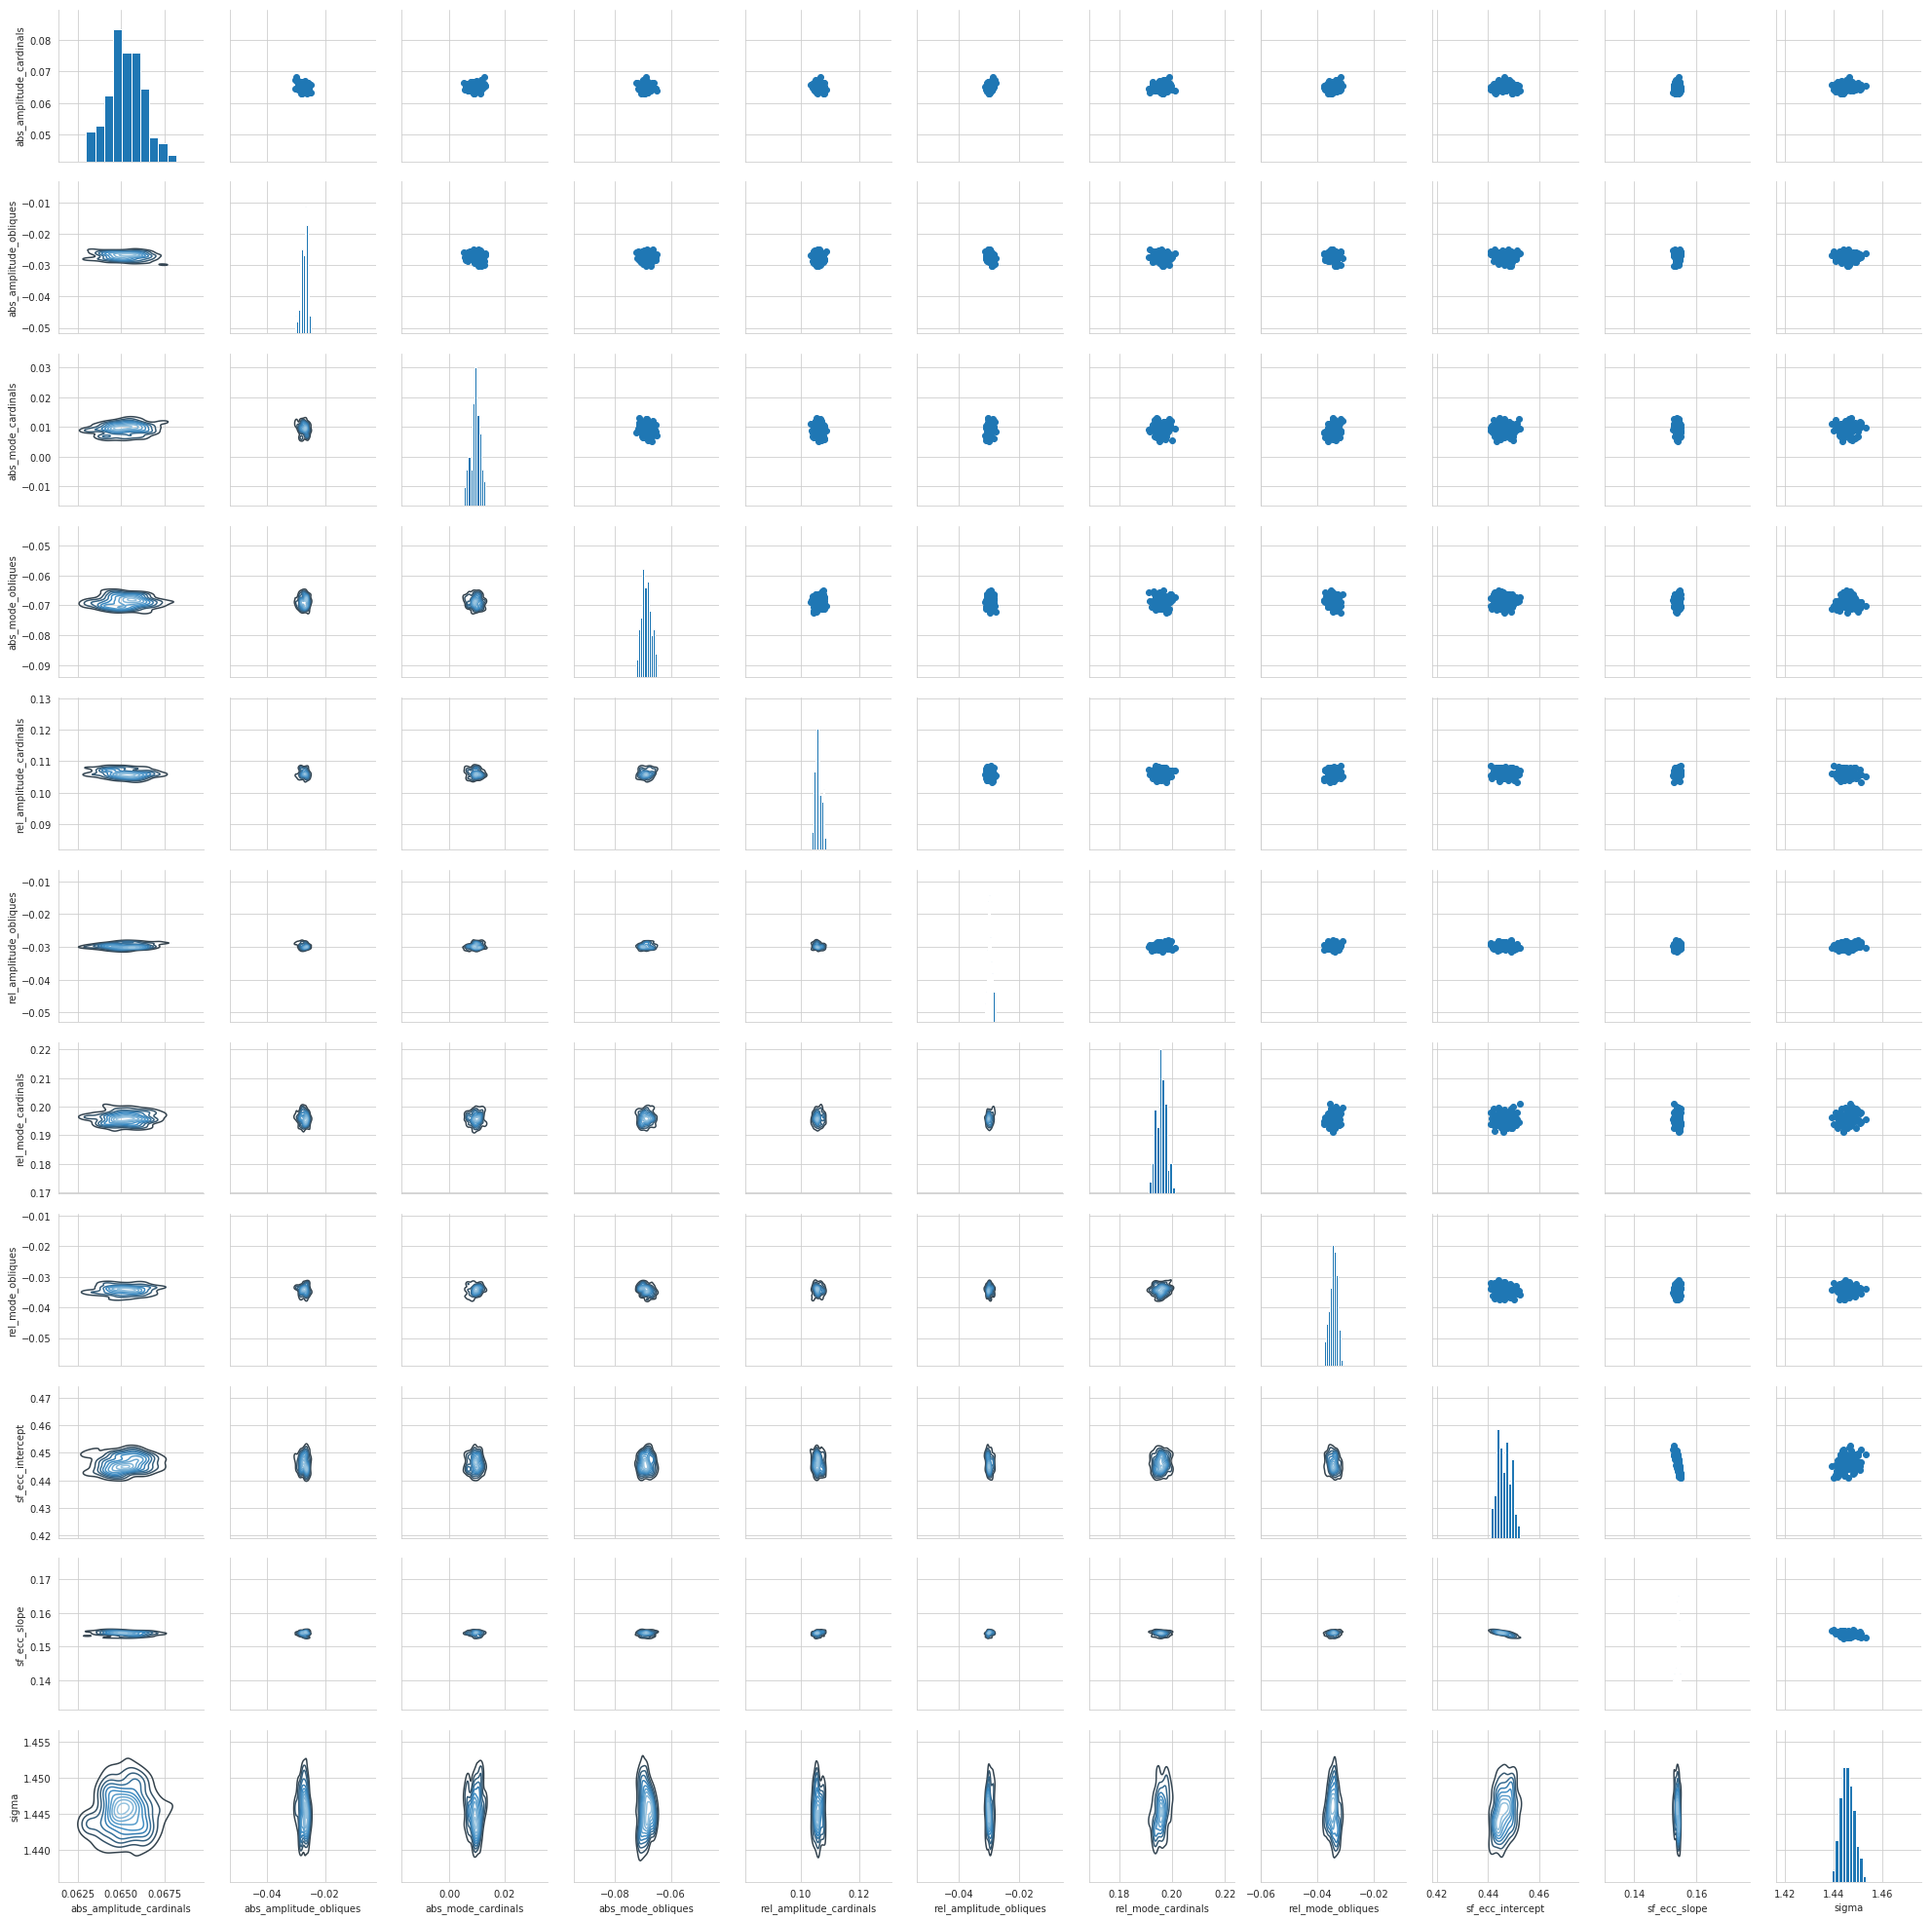

In [213]:
g = sns.PairGrid(samples.pivot('sample_num', 'model_parameter', 'value'))
g = g.map_upper(plt.scatter)
g = g.map_lower(sns.kdeplot, cmap="Blues_d")
g = g.map_diag(plt.hist)

/home/billbrod/miniconda3/envs/sfp/lib/python3.6/site-packages/matplotlib/tight_layout.py:231: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


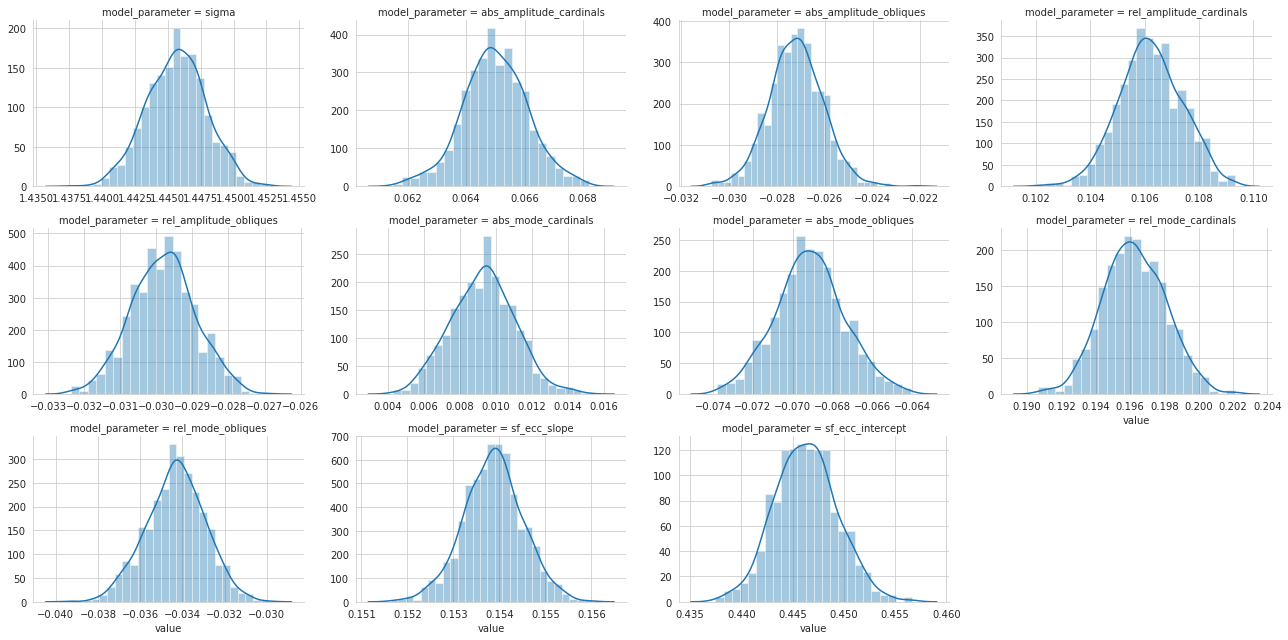

In [219]:
g = sns.FacetGrid(samples, col='model_parameter', col_wrap=4, sharex=False, sharey=False, aspect=1.5)
g.map(sns.distplot, 'value')

In [142]:
# cusum plot:
means = {}
cusum = {}
for p in params:
    means[p] = marginals.support()[p].mean()
    cusum[p] = []
    for t in range(len(marginals.support()[p])):
        cusum[p].append((marginals.support()[p][:t] - means[p]).sum())

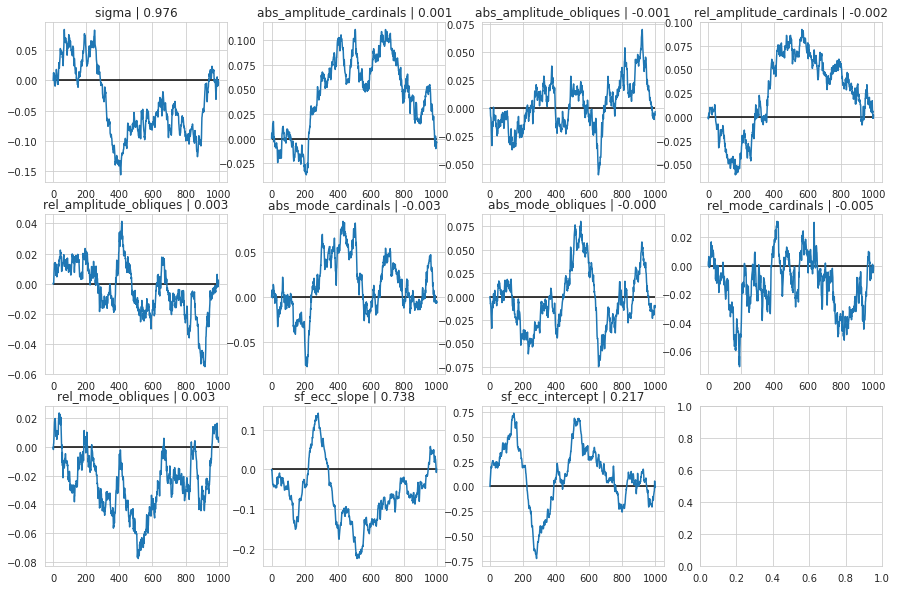

In [143]:
fig, axes = plt.subplots(3, 4, figsize=(15,10))
for ax, p in zip(axes.flatten(), params):
    ax.plot(cusum[p])
    ax.hlines(0, 0, len(cusum[p]))
    ax.set_title("%s | %.03f" % (p.replace('module$$$', ''), marginals.support()[p].mean()))

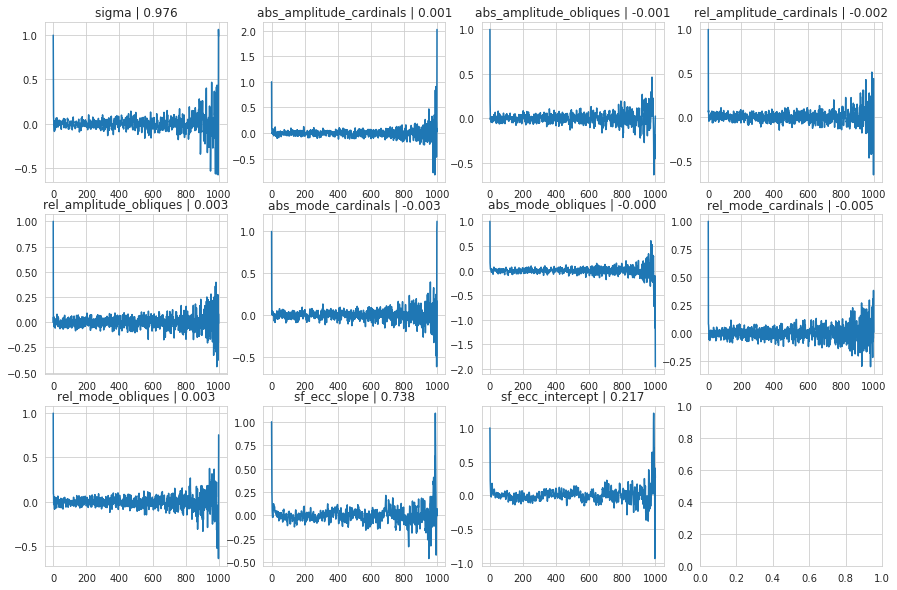

In [151]:
fig, axes = plt.subplots(3, 4, figsize=(15,10))
for ax, p in zip(axes.flatten(), params):
    ax.plot(pyro.ops.stats.autocorrelation(marginals.support()[p]).numpy())
    ax.set_title("%s | %.03f" % (p.replace('module$$$', ''), marginals.support()[p].mean()))